# Plot confidence region of dark halo

__last update__: 06/06/22

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
import copy
from tqdm import tqdm
import numpy as np
#import jax.numpy as jnp
import pickle as pkl
from skimage import feature
from astropy.io import fits
from scipy.optimize import minimize
import seaborn as sns # for nicer colors on the plot

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, ListedColormap, TwoSlopeNorm
from matplotlib import patches as mpatches
plt.rc('image', interpolation='none', origin='lower')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

from herculens.Util.plot_util import nice_colorbar, nice_colorbar_residuals

In [2]:
SAVE_FIGURE = False
figure_dir = os.path.join('figures', 'analyses')

In [3]:
scenario = 'real'
perturbation_type = 'dark_halo'
pixel_scale = 3
use_fit_grid = True

# load data
with open(os.path.join('results', f'sumplot-{scenario}-{perturbation_type}-scale_{pixel_scale}-smooth_source-init_from_smooth.pkl'), 'rb') as f:
    full_model_data = pkl.load(f)
with open(os.path.join('results', f'samples_HMC_n1600-{scenario}-{perturbation_type}-scale_{pixel_scale}-smooth_source-init_from_smooth.pkl'), 'rb') as f:
    hmc_model_data = pkl.load(f)

In [10]:
# get useful classes and coordinate grids
data, full_lens_image, full_kwargs_result, input_kwargs_result, \
    pot_mask_fitgrid, pot_noise_map, \
    perturb_input, perturb_input_fitgrid, \
    _, cov_matrix_pixpot, _, _, _, _ \
    = full_model_data

extent = full_lens_image.Grid.extent


if use_fit_grid:
    pixel_size = full_lens_image.Grid.model_pixel_width('lens')
    x_coords, y_coords = full_lens_image.Grid.model_pixel_axes('lens')
    x_grid, y_grid = full_lens_image.Grid.model_pixel_coordinates('lens')
else:
    pixel_size = full_lens_image.Grid.pixel_width
    x_coords, y_coords = full_lens_image.Grid.pixel_axes
    x_grid, y_grid = full_lens_image.Grid.pixel_coordinates

In [11]:
# model
pot_model_fitgrid = np.array(full_kwargs_result['kwargs_lens'][-1]['pixels'])

# error map
#pot_error_fitgrid = np.sqrt(np.abs(cov_matrix_pixpot))
#pot_error_fitgrid = pot_error_fitgrid.reshape(*pot_model_fitgrid.shape)

samples_hmc = hmc_model_data[3][0]
pot_error_fitgrid = np.std(samples_hmc[50:, 5:-7], axis=0).reshape(*pot_mask_fitgrid.shape)


if use_fit_grid:
    pot_model = np.copy(pot_model_fitgrid)
    pot_mask = pot_mask_fitgrid
    pot_error = pot_error_fitgrid
    
else:
    pot_model = full_lens_image.LensModel.potential(x_grid, y_grid, 
                                                    full_kwargs_result['kwargs_lens'],
                                                    k=-1)
    pot_model = np.array(pot_model)
    
    from herculens.Util.jax_util import BicubicInterpolator as Interpolator
    x, y = full_lens_image.Grid.model_pixel_axes('lens')
    interpolator = Interpolator(y, x, pot_error_fitgrid)
    pot_error = interpolator(y_grid, x_grid)
    interpolator = Interpolator(y, x, pot_mask_fitgrid)
    pot_mask = interpolator(y_grid, x_grid).astype(bool)


In [12]:
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

1.94 -0.4849999999999999
result 2D gaussian fit: [ 7.23657512  0.39511123 -0.0575561   0.07028901  1.87984217 -0.35881796]
fitted position: 1.879842167044107 -0.35881796422169254
fitted std dev: 0.3951112254210288
std dev along x, y: 0.3641588502730389 0.42869445665444283
0.0 7.047312


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: No contour levels were found within the data range.
/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: No contour levels were found within the data range.


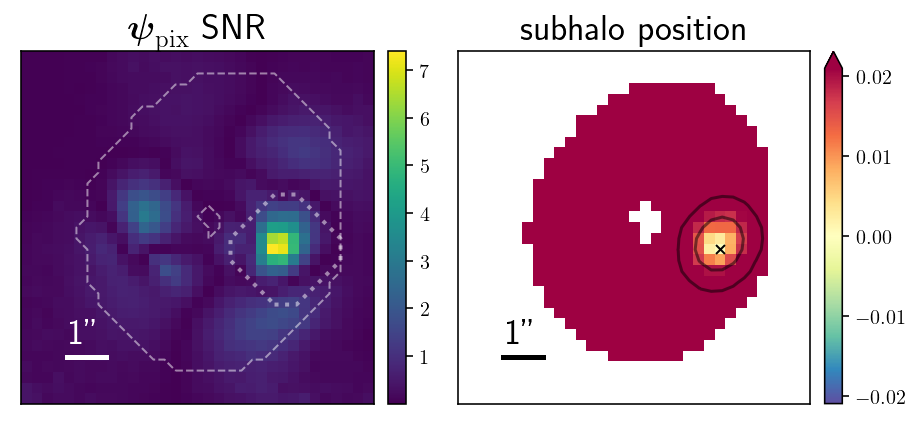

In [38]:
#snr_map = np.abs((pot_model - pot_model.min()) / pot_error)
snr_map = np.abs(pot_model_fitgrid / pot_error_fitgrid)
mask_snr = (snr_map > 3).astype(bool)
#pot_mask = mask_snr

sub_pos_idx = np.where(pot_model == pot_model[pot_mask == 1].min())
sub_x, sub_y = x_grid[sub_pos_idx][0], y_grid[sub_pos_idx][0]
print(sub_x, sub_y)

radius_sub = 1
mask_circ_sub = (np.hypot(x_grid-sub_x, y_grid-sub_y) <= radius_sub).astype(float)

import jax
from scipy.optimize import minimize
from herculens.LightModel.Profiles.gaussian import GaussianEllipse
from herculens.Util import param_util

def gaussian_2d(amp, sigma, e1, e2, center_x, center_y):
    return GaussianEllipse().function(x_grid, y_grid, 
                                      amp=amp, sigma=sigma, e1=e1, e2=e2,
                                      center_x=center_x, center_y=center_y)
def _loss_func(p):
    model = gaussian_2d(p[0], p[1], p[2], p[3], p[4], p[5])
    target = snr_map * mask_circ_sub
    return 0.5 * np.sum((model - target)**2)
#def _loss_func(p):
#    model = gaussian_2d(p[0], p[1], p[2], p[3], p[4], p[5])
#    pot_model_o = pot_model_fitgrid - pot_model_fitgrid[pot_mask == 1].min()
#    target = - pot_model_o * pot_mask * mask_circ_sub
#    return 0.5 * np.sum((model - target)**2 / pot_error**2)


_loss = jax.jit(_loss_func)
_grad = jax.jit(jax.grad(_loss_func))

res = minimize(_loss, [10., 0.5, 1e-3, 1e-3, sub_x, sub_y], jac=_grad, method='BFGS')
print("result 2D gaussian fit:", res.x)

gauss2d_params = res.x
_, axis_ratio = param_util.ellipticity2phi_q(gauss2d_params[2], gauss2d_params[2])
print("fitted position:", gauss2d_params[-2], gauss2d_params[-1])
sigma = np.abs(gauss2d_params[1])  # fit might give a negative sigma (expected since it appears as sigma**2 in the model)
print("fitted std dev:", sigma)
print("std dev along x, y:", sigma*np.sqrt(axis_ratio), sigma/np.sqrt(axis_ratio))

model_gauss2d = gaussian_2d(*gauss2d_params)
print(model_gauss2d.min(), model_gauss2d.max())
model_gauss2d /= model_gauss2d.max()  # normalize so max is 1
sigma_levels = [1-np.exp(-(1/num_sig)**2/2) for num_sig in [3, 1]]
#sigma_levels = [model_gauss2d.max() / 2]  # level at 1-sigma


fontsize = 18

fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
        
ax = axes[0]
ax.set_title(r"$\boldsymbol{\psi}_{\rm pix}$ SNR", fontsize=fontsize)
im = ax.imshow(snr_map, extent=extent) #, norm=LogNorm())
im.set_rasterized(True)
#im = ax.imshow(- pot_model_fitgrid * pot_mask, extent=extent) #, norm=LogNorm())
ax.contour(mask_circ_sub, extent=extent, levels=[1], linewidths=2, 
           colors='white', linestyles=':', alpha=0.5)
ax.contour(pot_mask, extent=extent, levels=[1], linewidths=1, 
           colors='white', linestyles='--', alpha=0.5)
#ax.scatter(sub_x, sub_y, c='white', s=40, marker='x', linewidth=1)
add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=0.5, 
              color='white', fontsize=fontsize, position=(extent[0]+4*pixel_size, extent[2]+4*pixel_size))
nice_colorbar(im)

ax = axes[1]
ax.set_title(r"subhalo position", fontsize=fontsize)
pot_model_o = pot_model - pot_model[pot_mask == 1].min()
trunc_fractor = 0.4  # tweak this such the plot looks like the model summary plot
vmax = np.abs(pot_model_o).max() * trunc_fractor
norm_pot = Normalize(-vmax, vmax)
im = ax.imshow(pot_model_o, extent=extent, 
               cmap='Spectral_r', norm=norm_pot)
im.set_rasterized(True)
pot_mask_nans = np.nan * np.zeros_like(pot_mask)
pot_mask_nans[pot_mask == 0] = 1
imm = ax.imshow(pot_mask_nans, extent=extent, cmap='gray_r')
imm.set_rasterized(True)
#ax.imshow(model_gauss2d, extent=extent)
ax.contour(model_gauss2d, extent=extent, 
           levels=sigma_levels, linewidths=1.5, colors='black', alpha=0.5)
ax.scatter(sub_x, sub_y, c='black', s=20, marker='x', linewidth=1)
add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=0.5, 
              color='black', fontsize=fontsize, position=(extent[0]+4*pixel_size, extent[2]+4*pixel_size))
nice_colorbar_residuals(im, pot_model_o, vmin=norm_pot.vmin, vmax=norm_pot.vmax)

fig.tight_layout()
plt.show()

In [15]:
if SAVE_FIGURE:
    figure_name = 'subhalo_position.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), dpi=300, bbox_inches='tight', transparent=False)

In [16]:
use_noise_map = False
num_samples = 10000
prng_seed = 8

In [63]:
def find_minimum(image, mask=None):
    minimum_index = np.where(image == image[mask == 1].min())
    x_minimum = x_coords[minimum_index[1]]
    y_minimum = y_coords[minimum_index[0]]
    return x_minimum, y_minimum

def sample_minima(model, error, mask):
    np.random.seed(prng_seed)
    xs, ys = [], []
    model_list = []
    #for n in range(num_samples):
    for n in range(50, 400):
        mu = pot_model # - pot_model.min()
        sigma = error
        #model_sample = mu + sigma * np.random.randn(*model.shape)
        model_sample = samples_hmc[n, 5:-7].reshape(*model.shape)
        
        #pixels_sample = pot_model + error * np.random.randn(*model.shape)
        #model_sample = full_lens_image.LensModel.potential(x_grid, y_grid, [{}, {}, {'pixels': pixels_sample}], k=-1)
        
        x, y = find_minimum(model_sample, mask=mask)
        xs.append(x[0])
        ys.append(y[0])
        model_list.append(model_sample)
    return xs, ys, model_list


radius_sub = 2
mask_circ_minima = (np.hypot(x_grid-sub_x, y_grid-sub_y) <= radius_sub).astype(float)

mask_choice = mask_snr  # mask_circ_minima

print(pot_model.shape, pot_error.shape, pot_mask.shape)
x_samples, y_samples, samples = sample_minima(pot_model, 
                                              pot_error,
                                              mask_choice)

(33, 33) (33, 33) (33, 33)


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys


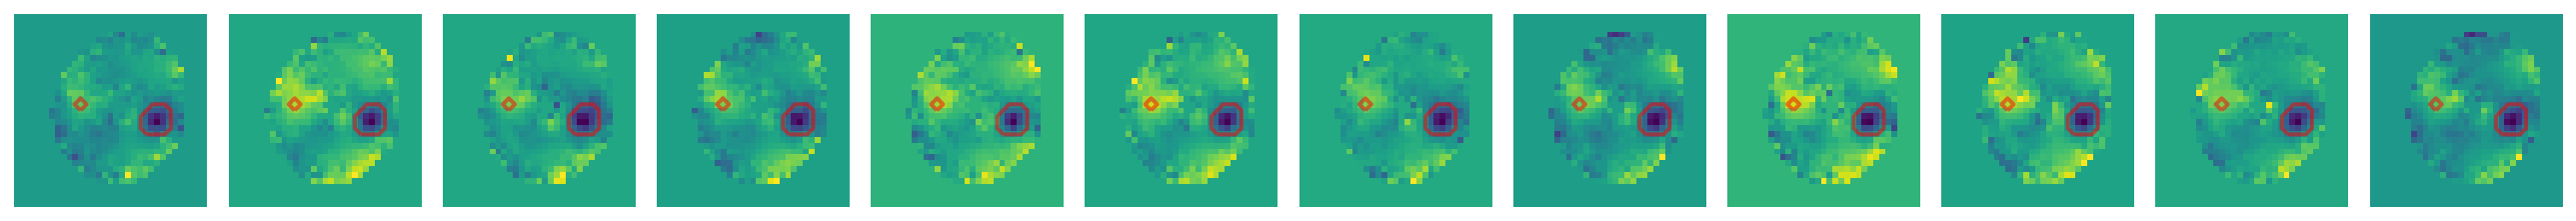

In [64]:
num_panels = 12
fig, axes = plt.subplots(1, num_panels, figsize=(18, 8))
for i, ax in enumerate(axes):
    ax.axis('off')
    im = ax.imshow(samples[i] * pot_mask, extent=extent) #, norm=LogNorm())
    ax.contour(mask_choice, extent=extent, levels=[1], linewidths=2, 
               colors='red', linestyles='-', alpha=0.5)
    #fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

In [65]:
print(sub_x, sub_y)
print(np.std(x_samples), np.std(y_samples))

1.94 -0.4849999999999999
0.04040016669999968 0.01827882682789245


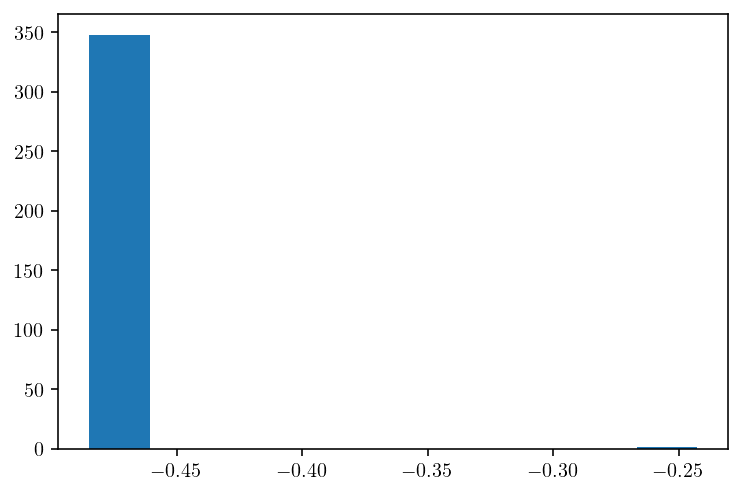

In [67]:
plt.hist(y_samples)
plt.show()

/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


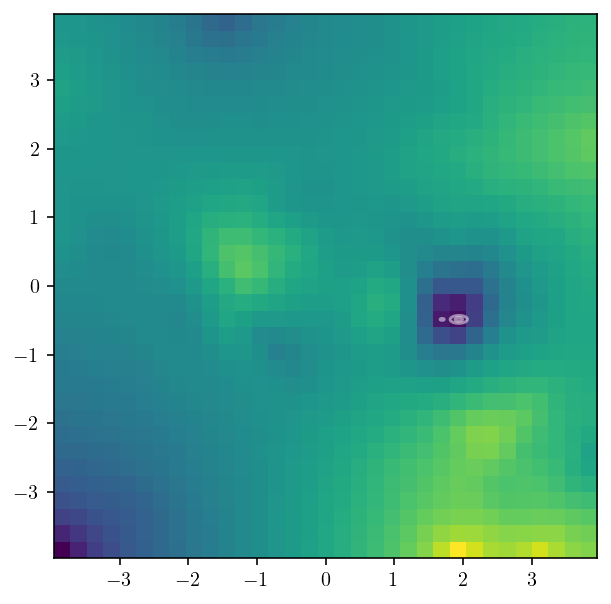

In [57]:
import seaborn as sns

fig, axes = plt.subplots(figsize=(5, 5))
ax = axes
ax.imshow(pot_model_fitgrid, extent=extent)
#ax.imshow(np.std(samples, axis=0), extent=extent, norm=LogNorm())
#ax.imshow(np.median(samples, axis=0), extent=extent)
sns.kdeplot(x_samples, y_samples, extent=extent, bw_adjust=3, levels=3, color='white', alpha=0.5)
plt.show()